# Analyze the commit histories from the scraper


I this notebook, we aim to identify *feature flagging* projects by analyzing commits that contain *feature flagging* phrases which we scraped from GitHub.

In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import statistics
from github import Github
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

# Phase 1: Initial Sampling
We collected all commits from github that contain *feature flagging* identifiers

In [2]:
df = pd.read_csv("feature_all_commits.csv", sep=';', header=0, encoding = "ISO-8859-1")
df = df.drop_duplicates()
df.fillna('', inplace=True)

counts = df['slug'].value_counts()
print("Number of projects: %d" % len(counts))
print("Number of commits: %d" % len(df))

Number of projects: 231223
Number of commits: 3918003


# Phase 2: Data Cleaning
As there are too many commits, we first need to filter the collected data.
* 2.1, filter by number of *feature flagging* commits (>=10)
* 2.2, remove duplicate projects, i.e., projects that are clones (not forks)

### 2.1, filter by number of commits 

In [3]:
min_nr_commits = 10
df = df[df['slug'].isin(df['slug'].value_counts()[df['slug'].value_counts()>=min_nr_commits].index)]

counts = df['slug'].value_counts()
print("Number of projects (commits >= %d): %d" % (min_nr_commits, len(counts)))
print("Number of commits: %d" % len(df))

Number of projects (commits >= 10): 48512
Number of commits: 3507783


### Manually classified projects
In the following lists, we store the *manually* classified projects:
* **none_feature_flag_repos**: projects that do not use feature flagging
* **clones**: cloned projects that were not detected in our filtering
* **dont_know**: projects where we are not sure how and for what purpose they use flags
* **feature_flag_repos**:projects that use feature flags

In [4]:
none_feature_flag_repos = ['torvalds/linux', 'git-portage/git-portage', 'obache/xxxsrc', 'piyawad/test1', 'CTSRD-CHERI/cheribsd', 'marco-c/gecko-dev-wordified', 'witwall/icu46', 'sambler/myblender', 'jyin0813/OpenBSD-src','glk/freebsd-head', 'geogebra/geogebra', 'yaomeiguan/epiphany-sourceware', 'frida/v8',
                           'navsystem/gentoo-portage', 'virtbsd/virtbsd', 'aosp-mirror/platform_external_skia', 'davidswelt/aquamacs-emacs-pre2015', 'llvm-mirror/llvm', 'oyvindberg/ScalablyTyped', 'PuniCZ/soulcore', 'wzrdtales/tdb', 'chapel-lang/chapel', 'llvm-project/llvm-project-20170507', 'freebsd/freebsd-ports-gnome', 
                           'openstack/openstack', 'apache/subversion', 'hisilicon/qemu', 'maldini03/redkancut', 'navsystem/gentoo-portage', 'virtbsd/virtbsd', 'aosp-mirror/platform_external_skia', 'davidswelt/aquamacs-emacs-pre2015', 'llvm-mirror/llvm', 'oyvindberg/ScalablyTyped', 'PuniCZ/soulcore', 'wzrdtales/tdb', 
                           'chapel-lang/chapel', 'llvm-project/llvm-project-20170507', 'freebsd/freebsd-ports-gnome', 'openstack/openstack', 'apache/subversion', 'hisilicon/qemu', 'maldini03/redkancut', 'bminor/mesa-mesa', 'joker-eph/clangllvm', 'jmckaskill/subversion', 'guix-mirror/guix', 'mutoso-mirrors/linux-historical',
                           'scummvm/scummvm', 'CleverRaven/Cataclysm-DDA', 'twitter-forks/mysql', 'DragonFlyBSD/DragonFlyBSD', 'obache/nul', 'dspinellis/linux-history-repo', 'pf3gnuchains/pf3gnuchains4x', 'yedaoq/icu46', 'linux-mailinglist-archives/linux-kernel.vger.kernel.org.0', 'davidl-zend/zenddbi', 'SHIFTPHONES/android_kernel_shift_mt6797',
                           'svn2github/subversion', 'markphip/subversion', 'Distrotech/evolution', '1367485513/riscv-binutils', '0xAX/emacs', '1095811981/studyCode', '1500WK1500/u-boot-nexusS', '10sr/gnumeric-gda', 'IIJ-NetBSD/netbsd-src', '79man/asan', '1g4-linux/binutils-gdb', '2asoft/freebsd-ports-my', 'simonpcook/llvm-clang-submodulerepo',
                           'habitat-sh/habitat', 'BitconFeng/Deep-Feature-video',
                           'AOEpeople/TYPO3-Feature-Flag', #feature flag library
                          ]

clones = ['0vert1m3/test', '0100111001000010/Homebrew', '0xfab-ri/ffmpeg', 'Havoc-OS/android_frameworks_base', 'AOSPSubstratum/frameworks_base', 'ekayy/eatlovegive', 'miju12/hardware_qcom-caf_sm8150', 'mitodl/reddit', 'Kazicata747/A.House',
         'dhruv0018/intelligence-web', # actual is krossoverintelligence/intelligence-web
         'tonado/openstack-dev', 'Alex-teach/Movoo', 'MilenMT/DistributedServerCache', 'ahmadgunn/android_kernel_whyred', 'XPerience-AOSP-Lollipop/android_kernel_leeco_msm8976', 'FanCooking/android_kernel_lk', 'project-draco-hr/neo4j', 'ParrotSec/linux-parrot',
         ]

dont_know = ['LibreOffice/core', 'gcc-mirror/gcc', 'mozilla/gecko-dev', 'webrtc-uwp/chromium-tools', 'bazelbuild/bazel', 'bloomberg/chromium.bb', 'tianocore/edk2', 'AidenFeng/EDKII', '10Dev/Blender3D', 'llvm-mirror/clang', '136060150/webrtc', 'llvm-mirror/compiler-rt', 'WordPress/gutenberg', 'AtomCommunity/hardware_qcom_audio-caf_sm8150',
             'iomintz/thumbnail-finder', # somehow not indexed
             'pavithracjs/atlassian-ui-library', # dont know how to scrape
             'Enalean/tuleap', # lots of flags that are not feature toggles
             'pavithracjs/atlassian-ui-library',
             'alphagov/whitehall', # does not really use the flags in the project
             'HeisenbergKernel/prima', # see https://github.com/HeisenbergKernel/prima/blob/4225852f6e7ed47819137b6c298093b57b588ad0/Kbuild
             'SuperiorOS/android_external_e2fsprogs', 'halfline/rhel7', # they use flags but I dont know what they actually use them for
             'Unity-Technologies/ScriptableRenderPipeline', 'Sravan-Devarapalli/Milestone-v0.920', 'openzfsonosx/zfs', 'alphagov/pay-connector', # unclear
             'SalesforceFoundation/Cumulus', # I dont know
             'eciis/web', # I dont know how they actually use toggles
             'Augmint/augmint-web', # too few flags see: https://github.com/Augmint/augmint-web/tree/staging/src/containers/account/index.js
            ]

feature_flag_repos = ['chromium/chromium', 'nelsonomuto/test-complexity', 'instructure/canvas-lms', 'dimagi/commcare-hq', 'Automattic/wp-calypso', 'gitlabhq/gitlabhq','stonedpebbles/inventory-check', 'kubernetes/kubernetes', 'crdroidandroid/android_frameworks_base', 'live-clones/launchpad', 'CodeNow/runnable-angular',
                      'juju/juju', 'Factlink/factlink-core', 'hypothesis/h', 'emberjs/ember.js', 'SIGLUS/lmis-moz-mobile', 'edx/edx-platform', 'rogerwang/WebKit_trimmed', 'CartoDB/cartodb', 'rust-lang/rust', 'alphagov/govuk-puppet', 'ceph/ceph', 'wordpress-mobile/WordPress-iOS', 'hello/suripu', 'WebKit/webkit', '1480c1/aom', 'aosp-mirror/platform_frameworks_base', 
                      'moneyadviceservice/frontend', 'Audiobay/audiobaymarketplace', 'department-of-veterans-affairs/vets-website', 'cfpb/cfgov-refresh', 'getsentry/sentry', 'dantehemerson/gitter-webap-mirror', 'sharetribe/sharetribe', 'ets-berkeley-edu/calcentral', 'department-of-veterans-affairs/caseflow', 'Aperta-project/Aperta', 'lupapiste/lupapiste',  
                      'keybase/client', 'circleci/frontend', 'cloudfoundry/cloud_controller_ng', 'franbow/shopware', 'VisualComposer/builder', 'facebook/react', 'UniversityofWarwick/tabula', 'reddit-archive/reddit', 'KaurAvneet/Oculo', 'PIH/mirebalais-puppet', 'gocd/gocd', 'Bootleggers-BrokenLab/packages_apps_Launcher3', 'hmcts/probate-frontend',
                      'dotnet/roslyn', 'Yoast/wordpress-seo', 'education/classroom', 'smbc-digital/iag-webapp', 'signalapp/Signal-iOS', 'fabric8-ui/fabric8-ui', 'influxdata/influxdb', 'letsencrypt/boulder', 'DoSomething/phoenix', 'wordpress-mobile/WordPress-Android', 'rets-ci/wp-rets-client', 'neo4j/neo4j', 'bundler/bundler', 
                      'uktrade/great-domestic-ui', 'vespa-engine/vespa', 'kangdroid-project/platform_cts', 'transcom/mymove', 'xapi-project/xen-api', 'ZeitOnline/vivi', 'carbon-design-system/carbon', 'alphagov/digitalmarketplace-supplier-frontend', 'kubernetes/kops', 'sonaproject/tempest', 'uktrade/data-hub-frontend', 'loomnetwork/loomchain',
                      'desktop/desktop', '4teamwork/opengever.core', 'newrelic/node-newrelic', 'emberjs/data', 'zalando/nakadi', 'all-of-us/workbench', 'DFE-Digital/schools-experience', 'matrix-org/matrix-react-sdk', 'spinnaker/deck', 'openstack/devstack', 'zooniverse/Panoptes', 'PIH/openmrs-module-mirebalais', 'travis-ci/travis-api',
                      'hmrc/mobile-help-to-save', 'dialogs/api-schema', 'tokio-rs/tracing', '18F/identity-idp', 'devgateway/ocvn', 'ministryofjustice/prison-visits-2', 'ccrpjournal/clinicalresearch', 'Yoast/javascript', 'rafaeljesus/newww', 'navikt/modiapersonoversikt', 'Opentrons/opentrons', 'woocommerce/woocommerce-ios', 'DFE-Digital/get-help-to-retrain', 
                      'tokio-rs/tokio']

### 2.2, filter out projects that are clones (not forks)
* remove the projects that have a commit with the same *SHA* (keep the project with more commits)
* remove the projects that have a commit whate *title + line changes* are the same (keep the projct with more commits)

In [5]:
known_roots = ["chromium/chromium", "torvalds/linux", "llvm-mirror/llvm", "WordPress/WordPress", 'aosp-mirror/platform_frameworks_base', 'instructure/canvas-lms', 'sharetribe/sharetribe']

In [6]:
'''removes clones if thier SHA changes is the same'''
def remove_clones_sha(df, slug, inplace=True):
    df_slug = df[df['slug'] == slug]
    
    shas = df_slug['sha'].values
    
    df_clones = df[df['sha'].isin(shas)]
    df_clones = df_clones[df_clones['slug'] != slug]
    
    if len(df_clones) > 0:
        df = df[~df['slug'].isin(df_clones['slug'].values)]
#         df.drop(df.loc[lambda df: df['slug'].isin(df_clones['slug'].values)].index, inplace=inplace)
    return df, df_clones['slug'].unique().tolist()


In [7]:
''' removes clones if thier title + line changes is the same
    Some clones have commits with new SHAs and the commit message may also be changed as well.'''
def remove_clones(df, slug, inplace=True):
    df_slug = df[df['slug'] == slug]
    df_slug = df_slug[(df_slug['title'].str.len() > 10) & (df_slug['changes'].str.len() > 10)]

    df_clones = df[(df['title_changes']).isin(df_slug['title_changes'])]
    df_clones = df_clones[df_clones['slug'] != slug]
    if len(df_clones) > 0:
        df.drop(df.loc[lambda df: df['slug'].isin(df_clones['slug'].values)].index, inplace=inplace)

    return df_clones['slug'].unique().tolist()


In [8]:
def get_slugs(df):
    slugs = []
    classified_slugs = known_roots + none_feature_flag_repos + feature_flag_repos + dont_know
    slugs += classified_slugs
    for slug in df['slug'].value_counts().keys():
        if slug not in classified_slugs:
            slugs.append(slug)
    return slugs

In [9]:
def remove_all_copies(df):
    # remove known clones
    df = df[~df['slug'].isin(clones)]
    
    # remove clones with same SHA
    removed_slugs = []
    for slug in tqdm(get_slugs(df)):
        if slug not in removed_slugs:
            df, new_removed_slugs = remove_clones_sha(df, slug)
            removed_slugs += new_removed_slugs

    # remove clones with same title + line change
    df['title_changes'] = df['title'] + df['changes']
    for slug in tqdm(get_slugs(df)):
        if slug not in removed_slugs:
            removed_slugs += remove_clones(df, slug)      
    df.drop(['title_changes'], axis=1)
    
    return df

In [10]:
df = remove_all_copies(df)

100%|██████████| 4132/4132 [01:43<00:00, 40.06it/s]


In [11]:
df_candidate_counts = df['slug'].value_counts()
df_candidate_counts.to_csv('candidate_projects.csv', header=['Flagging Commits'])
print("Number of projects (No clones): %d" % len(df_candidate_counts))
print("Number of commits: %d" % len(df))

Number of projects (No clones): 3239
Number of commits: 126067


### remove merge commits

In [12]:
df = df[~df['message'].str.match("Merge branch '[\w\-\/]+' into [\w\-\/]*")]
df = df[df['slug'].isin(df['slug'].value_counts()[df['slug'].value_counts()>=min_nr_commits].index)]

In [13]:
counts = df['slug'].value_counts()
print("Number of projects (No merges): %d" % len(counts))
print("Number of commits: %d" % len(df))

Number of projects (No merges): 3167
Number of commits: 124005


In [14]:
df.to_csv('commits_after_cleanup.csv', sep = ';', encoding = "ISO-8859-1")

# Phase 3: Assembling a Dataset of Feature Flagging Projects
From the remaining projects we need to manually (iteratively) identify likely feature flagging projects.
The following code is used fo the improved heuristic that orders projects by their likelyhood of using *feature flags*. We used this script to identify feature flagging projects.

In [15]:
'''Used to start the script direclty from here.'''
df = pd.read_csv('commits_after_cleanup.csv', sep=';', header=0, encoding = "ISO-8859-1")

In [16]:
df_feature_flags = df[df['slug'].isin(feature_flag_repos)]
print("Number of classified feature flagging projects: %d" % len(df_feature_flags['slug'].value_counts()))

Number of classified feature flagging projects: 100


In [17]:
df_unclassified = df
df_unclassified = df_unclassified[~df_unclassified['slug'].isin(none_feature_flag_repos)]
df_unclassified = df_unclassified[~df_unclassified['slug'].isin(clones)]
df_unclassified = df_unclassified[~df_unclassified['slug'].isin(dont_know)]
df_unclassified = df_unclassified[~df_unclassified['slug'].isin(feature_flag_repos)]

print("Number of unclassified projects: %d" % len(df_unclassified['slug'].value_counts()))

Number of unclassified projects: 3002


### Plot the distribution of query matches to feature flagging and non-feature flagging projects

In [18]:
def plot_query_distribution(repos, title=None):
    df_repos = df[df['slug'].isin(repos)]

    all_feature_flagging = ["feature flag", "feature toggle", "feature switch", 
                            "feature flipper", "feature gate", "feature bit"]
    
    all_removal = ["remove flag", "remove toggle", "cleanup flag", 
                   "cleanup toggle", "delete flag", "delete toggle"]

    query_strings = all_feature_flagging + all_removal
    
    queries = {}
    for query in query_strings:
        if ' ' in query:
            split = query.split(' ')
            queries[split[0] + ".{0,50}" + split[1]] = []

    queries['all feature flagging'] = []
    queries['all removal'] = []

    for query in queries:
        queries[query] = []
        for slug in repos:
            df_slug = df_repos[df_repos['slug'] == slug]
            totalCount = len(df_slug)
            if totalCount == 0:
                continue

            prog_1 = re.compile(query, flags=re.IGNORECASE)
            if query == 'all feature flagging':
                flagging_query = ''
                for q in all_feature_flagging:
                    flagging_query += '(' + q.split(' ')[0] + '.{0,50}' + q.split(' ')[1] + ')|'
                prog_1 = re.compile(flagging_query[0:-1], flags=re.IGNORECASE)
                
            if query == 'all removal':
                removal_query = ''
                for q in all_removal:
                    removal_query = removal_query + '(' + q.split(' ')[0] + '.{0,50}' + q.split(' ')[1] + ')|'
                prog_1 = re.compile(removal_query[0:-1], flags=re.IGNORECASE)
                
            count = 0
            for message in df_slug.message:
                if prog_1.search(message) is not None:
                    count = count + 1   
            queries[query].append(100 / totalCount * count)
        

    df_queries = pd.DataFrame(queries)
    plot = df_queries.plot.box(figsize=(5,2), showfliers = True, ylim=(-1,101))
    plt.xticks(rotation=90)
    return plot

Non feature flagging projects

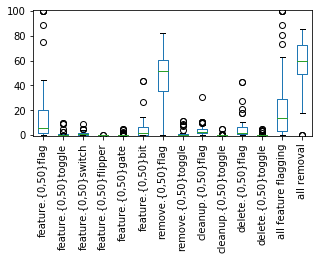

In [19]:
plot = plot_query_distribution(none_feature_flag_repos, 'non-flagging repos')
plt.gcf().subplots_adjust(bottom=0)
plot.get_figure().savefig('distribution_non_flagging.pdf', format='pdf', bbox_inches="tight")

Feature flagging projects

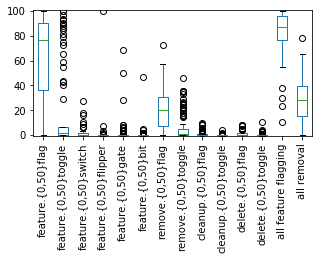

In [20]:
plot = plot_query_distribution(feature_flag_repos, 'flagging repos')
plt.gcf().subplots_adjust(bottom=0)
plot.get_figure().savefig('distribution_flagging.pdf', format='pdf', bbox_inches="tight")

### Sort and filter the remaining projects based on their likelyhood of using feature flags

In [21]:
# https://stackoverflow.com/questions/15325182/how-to-filter-rows-in-pandas-by-regex
df_filtered = df[df['slug'].isin(df['slug'].value_counts()[df['slug'].value_counts()>=10].index)]
df_filtered['message'].fillna('', inplace=True)
df_feature_flag_regexed = df_filtered[df_filtered['message'].str.contains(r'((feature.{0,50}flag)|(feature.{0,50}toggle)|(feature.{0,50}flipper))')]
# df_feature_flag_regexed = df_filtered[df_filtered['message'].str.contains(r'((feature flag)|(feature toggle)|(feature flipper))')]
series_counts_feature_flag_regexed = df_feature_flag_regexed['slug'].value_counts()

series_counts = df_filtered['slug'].value_counts()

df_counts_feature_flag_regexed = pd.DataFrame(list(series_counts_feature_flag_regexed.to_dict().items()), columns=['slug', 'regex_count'])
df_counts = pd.DataFrame(list(series_counts.to_dict().items()), columns=['slug', 'count_all'])

merged = pd.merge(df_counts_feature_flag_regexed,df_counts,on="slug")
merged = pd.DataFrame(zip(merged['slug'],100/merged['count_all']*merged['regex_count']), columns=['slug', 'percentage_regex'])
merged = pd.merge(merged, df_counts, on='slug')
merged = pd.merge(merged, df_counts_feature_flag_regexed, on='slug')

df_ff_projects = merged
df_ff_projects = df_ff_projects[~df_ff_projects['slug'].isin(feature_flag_repos)]
df_ff_projects = df_ff_projects[~df_ff_projects['slug'].isin(none_feature_flag_repos)]
df_ff_projects = df_ff_projects[~df_ff_projects['slug'].isin(clones)]
df_ff_projects = df_ff_projects[~df_ff_projects['slug'].isin(dont_know)]

df_ff_projects = df_ff_projects[df_ff_projects['percentage_regex'] > 30]

df_ff_projects = df_ff_projects[df_ff_projects['count_all'] > 25]
df_ff_projects.sort_values(by=['percentage_regex'], inplace=True, ascending=False)
df_ff_projects.head(20)

C:\Anaconda3\envs\feature flags\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,slug,percentage_regex,count_all,regex_count
124,fecgov/fec-cms,95.454545,44,42
37,moneyadviceservice/mas-cms-client,92.452830,106,98
151,uktrade/directory-ui-supplier,89.743590,39,35
156,Tenderly/tenderly-dashboard,89.473684,38,34
206,xinfangXXF/pouch-master,89.285714,28,25
164,habitat-sh/builder,88.888889,36,32
125,sourcegraph/sourcegraph,87.500000,48,42
185,shopgate/pwa,87.096774,31,27
165,simpledotorg/simple-android,86.486486,37,32
132,mozilla/fxa,86.363636,44,38


Select the project with the highest probability

,slug,percentage_regex,count_all,regex_count
124,fecgov/fec-cms,95.454545,44,42


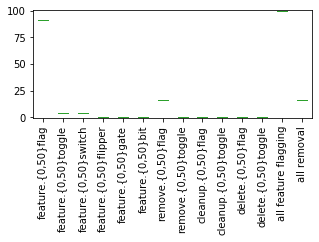

In [22]:
next_repo = df_ff_projects['slug'].values[0]

plot_query_distribution([next_repo], next_repo)
df_ff_projects.head(1)

### Find feature flagging file of the selected project
- files that appear often
- files that have very small changes (i.e. adding a single line)

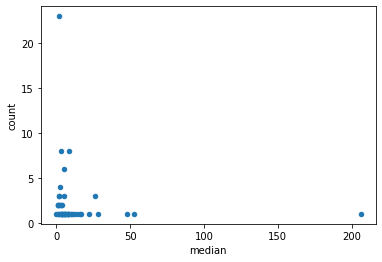

In [23]:
changes = df[df['slug'] == next_repo]['changes'].values

file_dict = {}
for change in changes:
    if len(change) == 2:
        continue
    split = change[2:-2].split('),(')
    for file_change in split:
        file_split = file_change.split(',')
        file = file_split[0].strip()
        if file not in file_dict:
            file_dict[file] = []
        additions = file_split[-2].strip()
        deletions = file_split[-1].strip()
        file_dict[file].append(int(additions) + int(deletions))

dict_data = {}
for f in file_dict:
    dict_data[f] = [statistics.median(file_dict[f]), statistics.mean(file_dict[f]), len(file_dict[f])]

df_changes = pd.DataFrame(dict_data).T
df_changes.columns = ['median', 'mean', 'count']
df_changes[['median', 'count']].plot.scatter(x='median', y='count')

In [24]:
df_changes = df_changes[(df_changes['median'] < 10)&(df_changes['count'] > 1)]
df_changes.sort_values(by=['count'], inplace=True, ascending=False)
df_changes

,median,mean,count
fec/fec/settings/base.py,2.0,2.521739,23.0
fec/fec/templates/base.html,3.5,4.125000,8.0
fec/legal/templates/legal/home.html,9.0,8.750000,8.0
fec/home/views.py,5.0,13.666667,6.0
fec/home/templates/home/latest_updates.html,2.5,2.750000,4.0
fec/data/templates/landing.jinja,2.0,26.000000,3.0
fec/legal/urls.py,5.0,6.000000,3.0
fec/data/api_caller.py,2.0,2.000000,3.0
manifest_prod.yml,1.5,1.500000,2.0
fec/home/templates/home/registration-and-reporting/landing_page.html,4.0,4.000000,2.0


In [25]:
gh = Github()
repo = gh.get_repo(next_repo)
master_name = repo.raw_data['default_branch']

The file with the most small changes

In [26]:
print('https://github.com/%s' % next_repo)
print('https://github.com/%s/tree/%s/%s' % (next_repo, master_name, df_changes.index[0]))

https://github.com/fecgov/fec-cms
https://github.com/fecgov/fec-cms/tree/develop/fec/fec/settings/base.py


The files ordered by their number of small changes

In [27]:
for file in df_changes.index:
    print('https://github.com/%s/tree/%s/%s' % (next_repo,master_name,file))

https://github.com/fecgov/fec-cms/tree/develop/fec/fec/settings/base.py
https://github.com/fecgov/fec-cms/tree/develop/fec/fec/templates/base.html
https://github.com/fecgov/fec-cms/tree/develop/fec/legal/templates/legal/home.html
https://github.com/fecgov/fec-cms/tree/develop/fec/home/views.py
https://github.com/fecgov/fec-cms/tree/develop/fec/home/templates/home/latest_updates.html
https://github.com/fecgov/fec-cms/tree/develop/fec/data/templates/landing.jinja
https://github.com/fecgov/fec-cms/tree/develop/fec/legal/urls.py
https://github.com/fecgov/fec-cms/tree/develop/fec/data/api_caller.py
https://github.com/fecgov/fec-cms/tree/develop/manifest_prod.yml
https://github.com/fecgov/fec-cms/tree/develop/fec/home/templates/home/registration-and-reporting/landing_page.html
https://github.com/fecgov/fec-cms/tree/develop/fec/data/templates/partials/advanced/raising.jinja
https://github.com/fecgov/fec-cms/tree/develop/fec/data/templates/partials/advanced/spending.jinja
https://github.com/fe

## Create a visualization of classified and potential projects (Figure 1)

In [28]:
df_filtered = df[df['slug'].isin(df['slug'].value_counts()[df['slug'].value_counts()>=10].index)]
df_filtered['message'].fillna('', inplace=True)
df_feature_flag_regexed = df_filtered[df_filtered['message'].str.contains(r'((feature.{0,50}flag)|(feature.{0,50}toggle)|(feature.{0,50}flipper))')]
#df_feature_flag_regexed = df_filtered[df_filtered['message'].str.contains(r'((feature flag)|(feature toggle)|(feature flipper))')]
series_counts_feature_flag_regexed = df_feature_flag_regexed['slug'].value_counts()

series_counts = df_filtered['slug'].value_counts()

df_counts_feature_flag_regexed = pd.DataFrame(list(series_counts_feature_flag_regexed.to_dict().items()), columns=['slug', 'regex_count'])
df_counts = pd.DataFrame(list(series_counts.to_dict().items()), columns=['slug', 'count_all'])

merged = pd.merge(df_counts_feature_flag_regexed,df_counts,on="slug")
merged = pd.DataFrame(zip(merged['slug'],(100/merged['count_all']*merged['regex_count'])), columns=['slug', 'percentage_regex'])
merged = pd.merge(merged, df_counts, on='slug')
merged = pd.merge(merged, df_counts_feature_flag_regexed, on='slug')

df_ff_projects = merged

C:\Anaconda3\envs\feature flags\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Number of likely feature flagging projects: 185


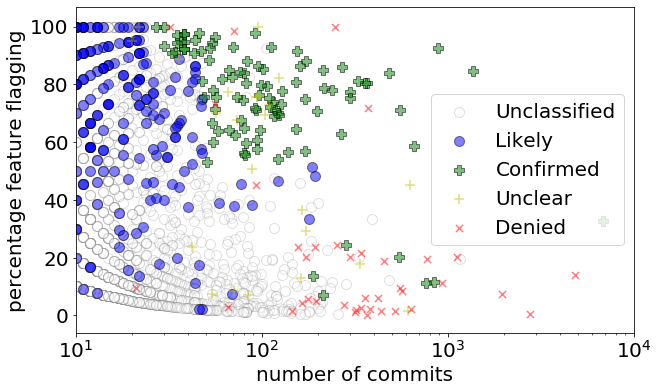

In [30]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(10,6))
plt.xscale('log')
ax.set_xlim(10,10000)

df_rest = df_ff_projects[~df_ff_projects['slug'].isin(none_feature_flag_repos)]
df_rest = df_rest[~df_rest['slug'].isin(feature_flag_repos)]
df_rest = df_rest[~df_rest['slug'].isin(clones)]
df_rest = df_rest[~df_rest['slug'].isin(dont_know)]

df_likely = df[df['slug'].isin(df_rest['slug'])]
df_likely = df_likely[df_likely['changes'].str.match(r'.*feature[\w\-_]*(flag|toggle).*')]

df_rest = df_rest[~df_rest['slug'].isin(df_likely['slug'])]
ax.scatter(df_rest['count_all'], df_rest['percentage_regex'], s=100,color='w',alpha=0.25,edgecolors='gray', label="Unclassified")

df_propable = df_ff_projects[df_ff_projects['slug'].isin(df_likely['slug'])]
print("Number of likely feature flagging projects: %d" % len(df_propable))
df_propable['slug'].to_csv('likely_projects.csv', index=False, header=['Slug'])

ax.scatter(df_propable['count_all'], df_propable['percentage_regex'], s=100,color='b',alpha=0.5,edgecolors='black', label="Likely")


df_feature_flag_repos = df_ff_projects[df_ff_projects['slug'].isin(feature_flag_repos)]
ax.scatter(df_feature_flag_repos['count_all'], df_feature_flag_repos['percentage_regex'], s=100,color='g',alpha=0.5,edgecolors='black', label="Confirmed", marker="P")
df_feature_flag_repos['slug'].to_csv('feature_flag_projects.csv', index=False, header=['Slug'])

df_dont_know = df_ff_projects[df_ff_projects['slug'].isin(dont_know)]
ax.scatter(df_dont_know['count_all'], df_dont_know['percentage_regex'], s=100, color='y',alpha=0.5,edgecolors='black', label="Unclear", marker='+')

df_none_feature_flag_repos = df_ff_projects[df_ff_projects['slug'].isin(none_feature_flag_repos)]
ax.scatter(df_none_feature_flag_repos['count_all'], df_none_feature_flag_repos['percentage_regex'], s=50,color='r',alpha=0.5,edgecolors='black', label="Denied", marker = 'x')


ax.legend()

ax.set_xlabel('number of commits')
ax.set_ylabel('percentage feature flagging')

fig.savefig('classified.pdf', format='pdf', bbox_inches="tight")